In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,CSVLogger,LambdaCallback,TensorBoard
from keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import seaborn as sns
import math
import os
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
%matplotlib inline

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
train_path = '../input/catdog10000train5000validate/train/train'
valid_path = '../input/catdog10000train5000validate/valid/valid'
test_path  = '../input/catdog10000train5000validate/test/test'
train_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    channel_shift_range=10.,
    fill_mode="nearest"
)
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

train_batches = train_gen.flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['dog', 'cat'], batch_size=32)

valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224), 
    classes=['dog', 'cat'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224),
    classes=['dog', 'cat'], batch_size=32,shuffle=False)


In [ ]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 1.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [ ]:
# Add all the call backs for Keras
lr_print_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: print("LearningRate of %e",model.optimizer.lr))

earlyStopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    verbose=0,
    mode='auto',
    baseline=None,
	patience=10,
    restore_best_weights=True
)

reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', 
	factor=0.1, 
    patience=7, 
	verbose=1, 
    min_delta=1e-4,
	mode='auto')
	
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', 
	factor=0.1, 
    patience=7, 
	verbose=1, 
    min_delta=1e-4,
	mode='auto')

mcp_save       = ModelCheckpoint(
    'cat_dog_ckpt.h5', 
	save_best_only=True, 
	monitor='val_loss', 
	mode='auto'
)
lrate_sched = LearningRateScheduler(step_decay)

csv_log = CSVLogger('train.csv', separator=',', append=False)


In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    plt.style.use('ggplot')
    cols = len(ims)/rows
    #cols = 8
    for i in range(len(ims)):
    #for i in range(10):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

#test_imgs, labels = next(test_batches)
#test_imgs, labels = next(train_gen)

#plots(aug_images, figsize=(20,7), rows=2)




In [ ]:
vgg19_model = VGG19()
#vgg16_model = VGG16() 
model_vgg19 = Sequential() 
for layer in vgg19_model.layers[:-1]: 
    model_vgg19.add(layer) 
for layer in model_vgg19.layers: 
    layer.trainable = False 
    
model_vgg19.add(Dense(2, activation='sigmoid'))


mcp_save       = ModelCheckpoint(
    'cat_dog_ckpt_vgg19.h5', 
	save_best_only=True, 
	monitor='val_loss', 
	mode='auto'
)
#print("Running the Training of Model from Scratch") 
#history = model_vgg16.fit_generator(generator=train_batches, steps_per_epoch=len(train_batches),
#                                    validation_data=valid_batches, validation_steps=len(valid_batches), 
#                                    epochs=50, verbose=1)



In [ ]:
if os.path.isfile('cat_dog_ckpt_vgg19.h5'):
    #This code is implemented to load the partly trained model which was stopped due to some reason
    print("Running the Partially Trained Model")
    partially_trained_model = load_model('cat_dog_ckpt_vgg19.h5')
    history = partially_trained_model.fit_generator(generator=train_batches, steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, validation_steps=len(valid_batches), 
                                    epochs=50,callbacks=[mcp_save], verbose=1)
else:
    print("Running the Training of Model from Scratch")
    model_vgg19.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
    history = model_vgg19.fit_generator(generator=train_batches, steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, validation_steps=len(valid_batches), 
                                    epochs=50,callbacks=[mcp_save], verbose=1)


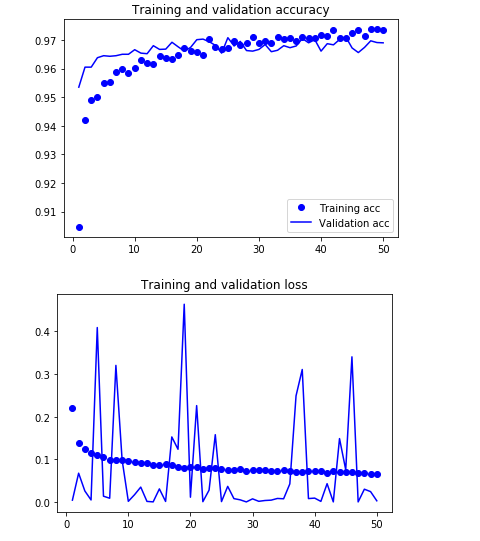

In [ ]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.savefig('accuracy.png')
plt.show()

In [ ]:
predictions = model_vgg16.predict_generator(generator=test_batches, steps=len(test_batches), verbose=0)
pred_label = np.argmax(predictions,axis=1)
classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion_matrix.png')

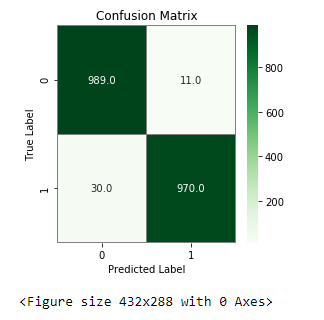

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tn + tp)/(tn + tp + fn +fp)
precision = precision_score(test_batches.labels, pred_label, average='binary')
recall = recall_score(test_batches.labels, pred_label,average='binary')
f1_score = f1_score(test_batches.labels, pred_label, average='binary')
score = metrics.accuracy_score(test_batches.labels, pred_label)
log_score = metrics.log_loss(pred_label, predictions)

In [ ]:
print("Precision ",precision*100)
print("Recall ",recall*100)
print("F1 Score ",recall*100)
print("Accuracy of the model",accuracy*100)
print("Accuracy score: {}".format(score))
print("Log loss score: {}".format(log_score))

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
plot_roc(pred_label,test_batches.labels)

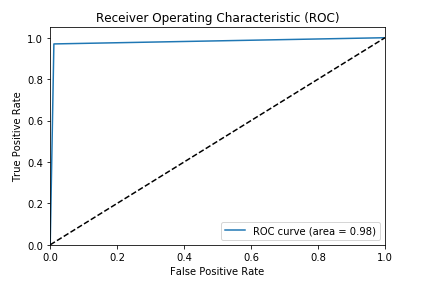